## Predicting Loan Default
Python version: python3.11.

## Set up the Environment
### Import Needed Libraries and Functions

In [25]:
# Data Manipulation and Visualization Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Preprocessing, Model Selection, and Evaluation
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Handling Imbalance and Metrics
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import accuracy_score


### Source the Data

In [2]:
# Load the data
data = pd.read_csv('./dataset.csv')

## Data Wrangling
Check if there are any missing or duplicate values.

In [3]:
# Check the data structure
#data.info()
#data.head()
#data['Accounts Delinquent'].unique()

# Check if there are any missing values
# data.isnull().sum()

# Check for duplicate rows
# data[data.duplicated()]

# Check the variables and ranges
data.nunique()

ID                              67463
Loan Amount                     27525
Funded Amount                   24548
Funded Amount Investor          67441
Term                                3
Batch Enrolled                     41
Interest Rate                   67448
Grade                               7
Sub Grade                          35
Home Ownership                      3
Employment Duration             67454
Verification Status                 3
Payment Plan                        1
Loan Title                        109
Debt to Income                  67454
Delinquency - two years             9
Inquires - six months               6
Open Account                       36
Public Record                       5
Revolving Balance               20582
Revolving Utilities             67458
Total Accounts                     69
Initial List Status                 2
Total Received Interest         67451
Total Received Late Fee         67380
Recoveries                      67387
Collection R

### Numeric Values Enforced

In [4]:
# List of columns to be enforced as numeric
columns_to_convert = [
    "Loan Amount",
    "Funded Amount",
    "Funded Amount Investor",
    "Interest Rate",
    "Employment Duration",
    "Debt to Income",
    "Revolving Balance",
    "Revolving Utilities",
    "Total Received Interest",
    "Total Received Late Fee",
    "Recoveries",
    "Collection Recovery Fee",
    "Total Collection Amount",
    "Total Current Balance",
    "Total Revolving Credit Limit",
    "Delinquency - two years",
    "Inquires - six months",
    "Open Account",
    "Total Accounts",
    "Public Record",
    "Collection 12 months Medical",
    "Last week Pay"
]

# Convert each column in the list to numeric
for column in columns_to_convert:
    data[column] = pd.to_numeric(data[column], errors='coerce')

### Object Variables Enforced

In [5]:
# As object
data[['Term','Inquires - six months','Public Record',
      'Collection 12 months Medical']] = data[['Term','Inquires - six months','Public Record',
                                               'Collection 12 months Medical']].astype('object')

### Valuable Predictors

Variables that likely are valuable:

Variables that won't be counted as predictors (assumption, many categories):
1. ID (left for reference when splitting the data); 
2. Batch Enrolled; 
3. Payment plan - 1 value only; 
4. Accounts Delinquent - 1 value only.
5. Loan Title to be dropped as this would require significant analysis. 

### Cardinality of Categorical Features 

In [6]:
# Identify columns with categorical data (dtype 'object')
categorical_columns = data.select_dtypes(include='object').columns

# Use a list comprehension to get feature names and their cardinalities
cardinality_list = [{'Feature': feature, 'Cardinality': data[feature].nunique()}
                    for feature in categorical_columns]

# Convert the list to a DataFrame
cardinality_df = pd.DataFrame(cardinality_list)

# Sort the DataFrame based on the cardinality in descending order
cardinality_df = cardinality_df.sort_values(by='Cardinality', ascending=False)

# Display the DataFrame with a background gradient for better visualization
display = cardinality_df.style.background_gradient(cmap='viridis')
display


,Feature,Cardinality
7,Loan Title,109
1,Batch Enrolled,41
3,Sub Grade,35
2,Grade,7
8,Inquires - six months,6
9,Public Record,5
0,Term,3
4,Home Ownership,3
5,Verification Status,3
10,Initial List Status,2


In [7]:
# Variables that shouldn't be counted as predictors (assumption here - Batch Enrolled).
#   Remove from the dataset.
data = data.drop(['Accounts Delinquent', 'Payment Plan', 'ID', 
                  'Batch Enrolled'], axis=1) #'Loan Title',

## Categorical Variables to be Encoded

1. Grade: ordinal nature (A-G), use manual mapping.
2. Loan Title: use manual mapping.
3. Home ownership: one-hot encoding.
4. Verification Status: one-hot encoding.
5. Initial List Status: label encoded since it has only two categories.
6. Application Type: label encoded since it has only two categories.
7. Loan Status: binary, rename it to "y".
8. Sub Grade: manual mapping as it has many values.

In [8]:
# 1. Grade
data['Grade'] = data['Grade'].map(data['Grade'].value_counts(normalize=True))

# 2. Loan Title
data['Loan Title'] = data['Loan Title'].map(data['Loan Title'].value_counts(normalize=True))

# 3. Home ownership
home_ownership_dummies = pd.get_dummies(data['Home Ownership'], prefix='HomeOwnership', drop_first=True)
data = pd.concat([data, home_ownership_dummies], axis=1)
data.drop('Home Ownership', axis=1, inplace=True)

# 4. Verification Status
verification_dummies = pd.get_dummies(data['Verification Status'], prefix='VerificationStatus', drop_first=True)
data = pd.concat([data, verification_dummies], axis=1)
data.drop('Verification Status', axis=1, inplace=True)

# 5. Initial List Status
data['Initial List Status'] = data['Initial List Status'].map({'w': 0, 'f': 1})

# 6. Application Type
data['Application Type'] = data['Application Type'].map({'JOINT': 0, 'INDIVIDUAL': 1})

# 7. Rename Loan Status to y
data.rename(columns={'Loan Status': 'y'}, inplace=True)

# 8. Sub Grade
data['Sub Grade'] = data['Sub Grade'].map(data['Sub Grade'].value_counts(normalize=True))

## Exploratory Data Analysis

### Visualise All Distributions

In [ ]:
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

for column in numeric_columns:
    data[column].value_counts().sort_index().plot(kind='bar', figsize=(10, 6))
    plt.title(f'Bar plot of {column}')
    plt.ylabel('Count')
    plt.xlabel(column)
    plt.show()

### Correlation Matrix

Correlation matrix reveals that there is little linear correlation between the predictors and the target variable.

y                                     1.000000
Initial List Status                   0.013445
HomeOwnership_OWN                     0.010585
Delinquency - two years               0.009990
Grade                                 0.009983
Total Current Balance                 0.009828
Total Received Late Fee               0.009365
Sub Grade                             0.008981
HomeOwnership_RENT                    0.008205
Total Collection Amount               0.007892
Open Account                          0.007073
Last week Pay                         0.006117
Loan Amount                           0.004473
Revolving Utilities                   0.004120
Collection Recovery Fee               0.003828
Employment Duration                   0.003716
Debt to Income                        0.003057
VerificationStatus_Source Verified    0.002952
Interest Rate                         0.002900
VerificationStatus_Verified           0.002587
Total Received Interest               0.001680
Total Revolvi

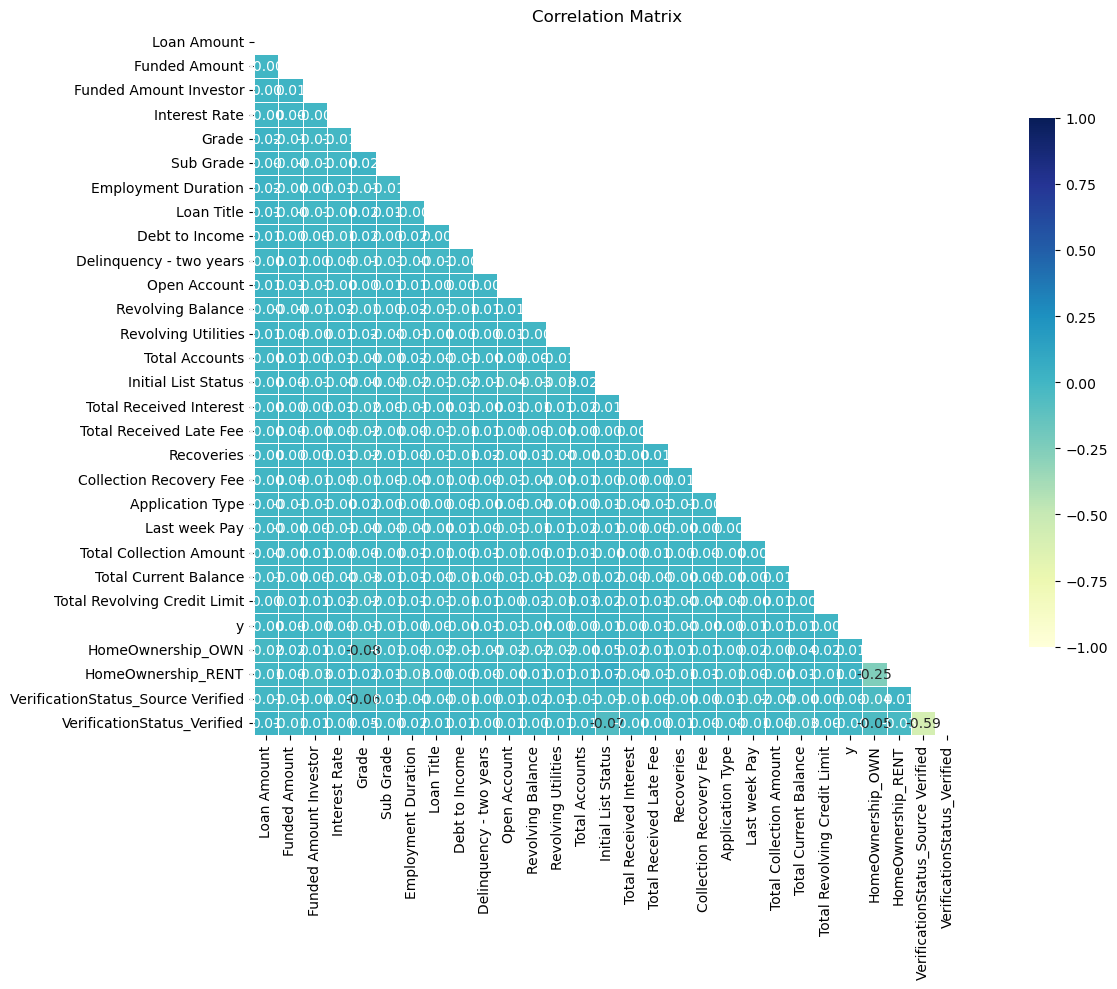

In [9]:
# Correlation matrix
corr_matrix = data.corr()

# Select the target variable 
target_corr = corr_matrix['y']

# Sort the correlations, descending
sorted_correlations = target_corr.abs().sort_values(ascending=False)

# Print the correlated features
print(sorted_correlations)

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap='YlGnBu', vmax=1, vmin=-1, center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.75}, annot=True, fmt=".2f")

plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

### Outlier Detection and Visualisation
1. Detecting Outliers using the IQR Method:
    a.For a given column, we calculate the Interquartile Range (IQR) which is the difference between the third quartile (Q3) and the first quartile (Q1).
    b. Define bounds for the outliers as:
        Lower Bound = Q1 - 1.5 * IQR
        Upper Bound = Q3 + 1.5 * IQR
    c. Any data point outside these bounds is considered an outlier.
2. Visualising the Data Distributions with Boxplots:
Boxplots provide a graphical representation of the central tendency and variability of the data, while also highlighting potential outliers.

In [10]:
# Define the function to detect outliers
def detect_outliers_iqr(data, column_name):
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column_name] < lower_bound) | (data[column_name] > upper_bound)]
    return outliers

# Example usage:
outliers = detect_outliers_iqr(data, 'Funded Amount')
print(outliers)

Empty DataFrame
Columns: [Loan Amount, Funded Amount, Funded Amount Investor, Term, Interest Rate, Grade, Sub Grade, Employment Duration, Loan Title, Debt to Income, Delinquency - two years, Inquires - six months, Open Account, Public Record, Revolving Balance, Revolving Utilities, Total Accounts, Initial List Status, Total Received Interest, Total Received Late Fee, Recoveries, Collection Recovery Fee, Collection 12 months Medical, Application Type, Last week Pay, Total Collection Amount, Total Current Balance, Total Revolving Credit Limit, y, HomeOwnership_OWN, HomeOwnership_RENT, VerificationStatus_Source Verified, VerificationStatus_Verified]
Index: []

[0 rows x 33 columns]


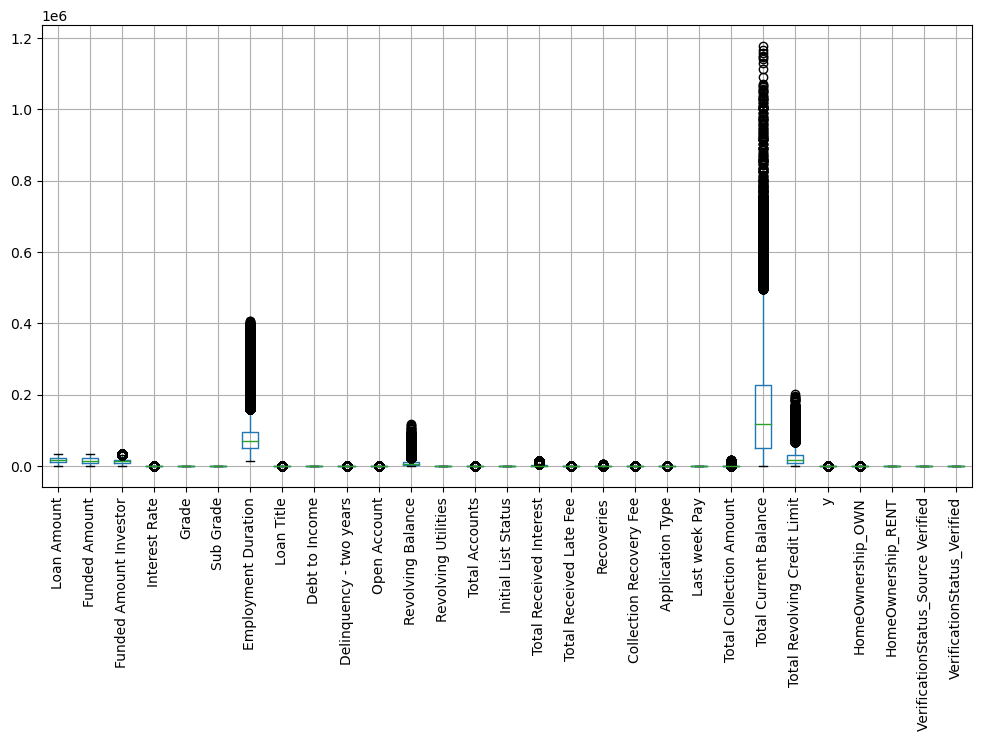

In [11]:
# Boxplots
plt.figure(figsize=(12, 6))
data.boxplot()
plt.xticks(rotation=90)
plt.show()

## Plot Loan Status and Interest Rate

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


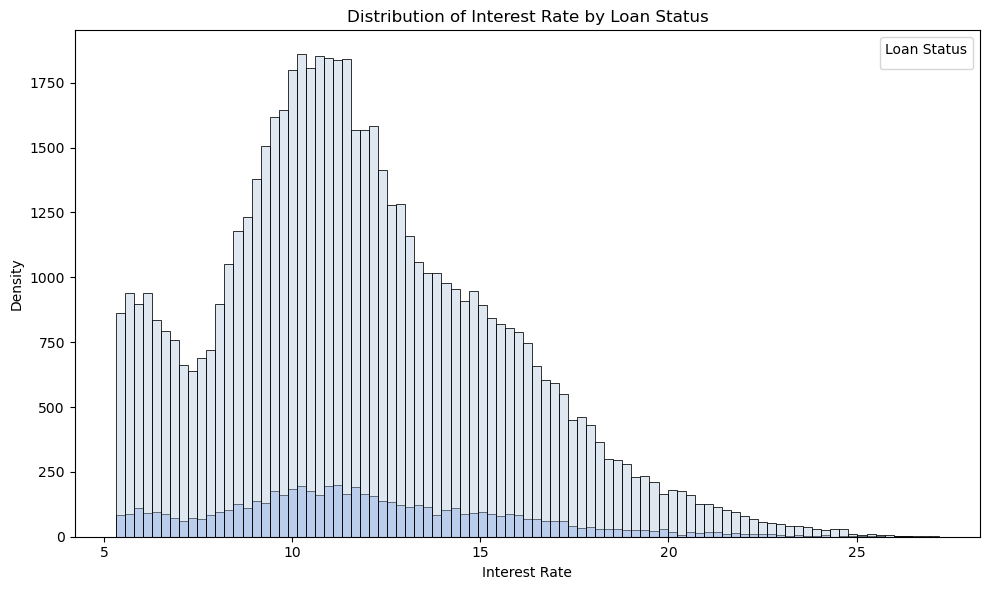

In [12]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Plotting
colors = ['lightsteelblue', 'cornflowerblue']

# Plot the histogram
sns.histplot(data=data, x='Interest Rate',
             hue='y', palette=colors, alpha=0.4)

# Set the title and labels
plt.title('Distribution of Interest Rate by Loan Status')
plt.xlabel('Interest Rate')
plt.ylabel('Density')
plt.legend(title='Loan Status')

# Display the plot
plt.tight_layout()
plt.show()

## Data Balance

The dataset is heavily imbalanced. Ways to deal with an imbalanced data set: nothing and evaluating the model with the correct performance metric, in this case, it could be Precision; SMOTE (Synthetic Minority Oversampling TEchnique), under-sampling, over-sampling, ADASYN.

0    61222
1     6241
Name: y, dtype: int64


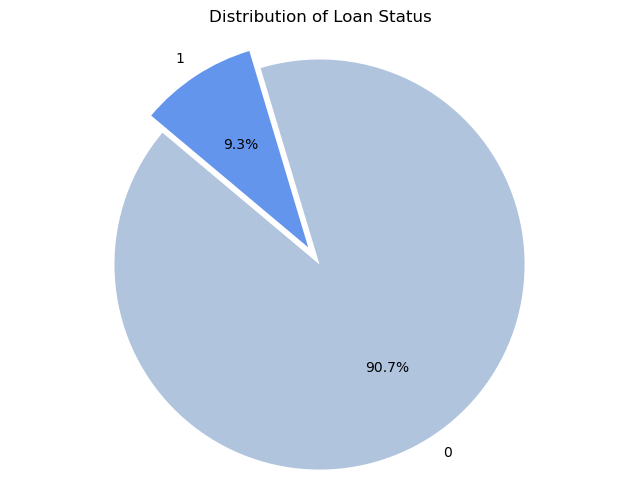

In [13]:
# Get the counts of each unique value in the 'Loan Status' column
loan_status_counts = data['y'].value_counts()
print(loan_status_counts)

# Plotting
colors = ['lightsteelblue', 'cornflowerblue']
# Explode the 1st slice for emphasis
explode = (0.1, 0)

# Plot a pie chart
plt.figure(figsize=(8, 6))
plt.pie(loan_status_counts, labels=loan_status_counts.index, colors=colors,
        autopct='%1.1f%%', startangle=140, explode=explode)

plt.title('Distribution of Loan Status')
# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')
plt.show()

## Split into Train and Test

In [14]:
# Splitting the data into a training set and a test set
X = data.drop('y', axis=1)
y = data['y']

# Split the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Data Transformation
Log(x+1) transformation was tested out, standardisation too, but Robust scaler proved to be best. Perform transformations after splitting to prevent leakage.

### Log Transformation

As a lot of distributions are right-skewed, apply Log trasformation to see if the training of models improves.

In [ ]:
# Identify numeric columns
#numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Apply log transformation to the training data
#X_train[numeric_cols] = np.log1p(X_train[numeric_cols])

# Apply the same transformation to the test data
#X_test[numeric_cols] = np.log1p(X_test[numeric_cols])

### Standardisation

In [ ]:
# Fit the scaler on the training data
#scaler = StandardScaler()
#scaler.fit(X_train)

# Transform the training data
#X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

# Transform the test data using the same scaler
#X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)


### Robust Scaler

In [16]:
# Fit the scaler on the training data
scaler = RobustScaler()
scaler.fit(X_train)

# Transform the training data
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

# Transform the test data using the same scaler
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

## Balance Data

SMOTE and ADASYN tested, SMOTE yields better results. It will still be hard to predict 1's.

In [17]:
# Save the algorithm
smote = SMOTE(random_state=42)

# Resample using SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Checking the distribution after SMOTE
print(pd.Series(y_train_resampled).value_counts())

0    48977
1    48977
Name: y, dtype: int64


In [ ]:
# Initialize ADASYN
#adasyn = ADASYN(random_state=42)

# Resample using ADASYN
#X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)
# Checking the distribution after ADASYN
#print(pd.Series(y_train_resampled).value_counts())


## Model Fitting

Models to be tested: Logistic Regression, Decision Tree, Random Forest, K-Nearest Neighbours classifiers.
Logistic Regression should perform better in cases where there is clear linear relationship. To avoid wasting time, I have continued with the Decision Tree to try capture more complex, non-linear relationships. As the Decision Tree with default settings was overfitting the data, I performed some fine-tuning on this model.

In [18]:
# Define the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

# Initialize lists to store results
train_acc = []
test_acc = []
model_names = []

# Train each model and store their accuracy
for name, model in models.items():
    # Fit the model on the resampled training data
    model.fit(X_train_resampled, y_train_resampled)
    
    # Predict on both training and test data
    ypred_train = model.predict(X_train_resampled)
    ypred_test = model.predict(X_test_scaled)
    
    # Calculate accuracy for training data and append to list
    train_acc.append(accuracy_score(y_train_resampled, ypred_train))
    
    # Calculate accuracy for test data and append to list
    test_acc.append(accuracy_score(y_test, ypred_test))
    
    # Append model name to list
    model_names.append(name)

### Model Evaluation

In [19]:
print(train_acc)

[0.5117708312064847, 1.0, 1.0, 0.8805051350633971]


In [20]:
print(test_acc)

[0.5708886089083228, 0.43289112873341734, 0.8660787074779516, 0.9075075965315349]


### Continue with Other Metrics to Evaluate the Performance on Test Data

In [22]:
# Initialize dictionaries to store results
metrics = {
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": [],
    "AUC-ROC": [],
    "TP": [],  # True Positives
    "FP": [],  # False Positives
    "TN": [],  # True Negatives
    "FN": []   # False Negatives
}

# Train each model and store their metrics
for name, model in models.items():
    # Predict on test data
    ypred_test = model.predict(X_test_scaled)
    
    # Extract confusion matrix values
    TN, FP, FN, TP = confusion_matrix(y_test, ypred_test).ravel()
    
    # Store confusion matrix values
    metrics["TP"].append(TP)
    metrics["FP"].append(FP)
    metrics["TN"].append(TN)
    metrics["FN"].append(FN)
    
    # Calculate and store other metrics
    metrics["Accuracy"].append(accuracy_score(y_test, ypred_test))
    metrics["Precision"].append(precision_score(y_test, ypred_test))
    metrics["Recall"].append(recall_score(y_test, ypred_test))
    metrics["F1-Score"].append(f1_score(y_test, ypred_test))
    metrics["AUC-ROC"].append(roc_auc_score(y_test, ypred_test))

# Print the results
for name in model_names:
    index = model_names.index(name)
    print(f"Metrics for {name}:")
    for metric, values in metrics.items():
        print(f"{metric}: {values[index]:.4f}")
    print("-" * 50)


Metrics for Logistic Regression:
Accuracy: 0.5709
Precision: 0.0998
Recall: 0.4535
F1-Score: 0.1635
AUC-ROC: 0.5182
TP: 566.0000
FP: 5108.0000
TN: 7137.0000
FN: 682.0000
--------------------------------------------------
Metrics for Decision Tree:
Accuracy: 0.4329
Precision: 0.0901
Recall: 0.5641
F1-Score: 0.1554
AUC-ROC: 0.4918
TP: 704.0000
FP: 7108.0000
TN: 5137.0000
FN: 544.0000
--------------------------------------------------
Metrics for Random Forest:
Accuracy: 0.8661
Precision: 0.0990
Recall: 0.0553
F1-Score: 0.0710
AUC-ROC: 0.5020
TP: 69.0000
FP: 628.0000
TN: 11617.0000
FN: 1179.0000
--------------------------------------------------
Metrics for K-Nearest Neighbors:
Accuracy: 0.9075
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
AUC-ROC: 0.5000
TP: 0.0000
FP: 0.0000
TN: 12245.0000
FN: 1248.0000
--------------------------------------------------


/Users/ernakuginyte/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Proceed with Decision Tree as explained above.

## Decision Tree Fine-Tuning

Training accuracy is much greater than test accuracy with default settings of Decision Tree and Random Forest classifiers - models are overfit. Hyperparameter tuning might be helpful.

In [23]:
# Define the hyperparameters and their possible values
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the model on the resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters and estimator
best_params = grid_search.best_params_
best_tree = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")

# Predict using the best model
ypred_train_best = best_tree.predict(X_train_resampled)
ypred_test_best = best_tree.predict(X_test_scaled)

# Calculate and print the accuracies
train_acc_best = accuracy_score(y_train_resampled, ypred_train_best)
test_acc_best = accuracy_score(y_test, ypred_test_best)

print(f"Training Accuracy (Fine-tuned): {train_acc_best:.4f}")
print(f"Test Accuracy (Fine-tuned): {test_acc_best:.4f}")

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


/Users/ernakuginyte/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1080 fits failed out of a total of 4320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
271 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ernakuginyte/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ernakuginyte/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Users/ernakuginyte/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 638, in _validate_params
    va

Best Parameters: {'criterion': 'gini', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'best'}
Training Accuracy (Fine-tuned): 0.9685
Test Accuracy (Fine-tuned): 0.4488


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.44      0.59     12245
           1       0.09      0.56      0.16      1248

    accuracy                           0.45     13493
   macro avg       0.50      0.50      0.37     13493
weighted avg       0.83      0.45      0.55     13493



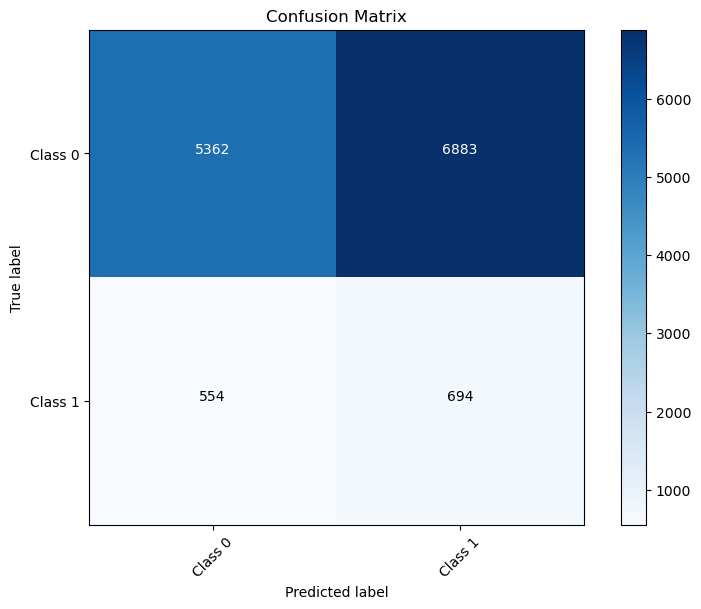

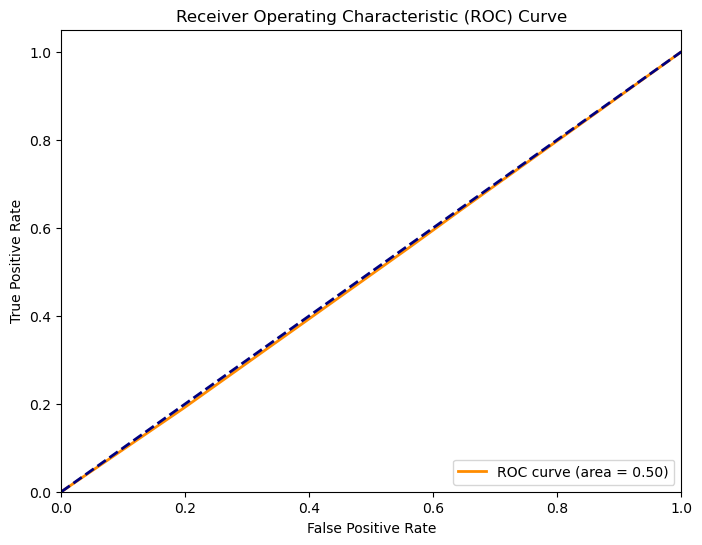

In [26]:
# 1. Print Classification Report
print("Classification Report:")
print(classification_report(y_test, ypred_test_best))

# 2. Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test, ypred_test_best)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = [0, 1]
plt.xticks(tick_marks, ['Class 0', 'Class 1'], rotation=45)
plt.yticks(tick_marks, ['Class 0', 'Class 1'])
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Annotate the cells with the absolute values
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, conf_matrix[i, j],
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.show()

# 3. Plot ROC-AUC Curve
y_prob_best = best_tree.predict_proba(X_test_scaled)[:, 1]  # probabilities for positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob_best)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [27]:
# Define the hyperparameters and their possible values
param_distributions = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

# Initialize the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_distributions=param_distributions,
    n_iter=100,  
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    # for reproducibility
    random_state=42  
)

# Fit the model on the resampled training data
random_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters and estimator
best_params = random_search.best_params_
best_tree = random_search.best_estimator_

print(f"Best Parameters: {best_params}")

# Predict using the best model
ypred_train_best = best_tree.predict(X_train_resampled)
ypred_test_best = best_tree.predict(X_test_scaled)

# Calculate and print the accuracies
train_acc_best = accuracy_score(y_train_resampled, ypred_train_best)
test_acc_best = accuracy_score(y_test, ypred_test_best)

print(f"Training Accuracy (Fine-tuned): {train_acc_best:.4f}")
print(f"Test Accuracy (Fine-tuned): {test_acc_best:.4f}")


Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/ernakuginyte/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
135 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
102 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ernakuginyte/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ernakuginyte/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Users/ernakuginyte/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 638, in _validate_params
    vali

Best Parameters: {'splitter': 'best', 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 40, 'criterion': 'gini'}
Training Accuracy (Fine-tuned): 0.9662
Test Accuracy (Fine-tuned): 0.4107


## Results

The final Decision Tree model was fine-tuned and its performance is - very poor. With low weighted accuracy, it could not be trusted for any predictions.
Best Parameters: {'criterion': 'gini', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'best'}
Training Accuracy (Fine-tuned): 0.9685, Test Accuracy (Fine-tuned): 0.4488.

This could be for reasons of:

1. Missclassifications are happening for the category 1 - "Defaulter", the number of entries for this response in the data was lower than 10% and this imbalance definitely causes issues in classification tasks. This was happening even after addressing the issue of imbalance by using SMOTE algorithm.
2. The features used might not capture all the nuances of a loan applicant's likelihood to default. Important predictors might be missing from the dataset.
3. The Decision Tree algorithm, while interpretable, might not be the most suitable model for this kind of data. More complex models like Random Forests or Gradient Boosted Trees might perform better.
4. The quality of the data might be questionable, there are plenty of outliers, that affect the model's performance.
5. The preprocessing steps, including encoding of categorical variables, or scaling of features, might not be optimal for the algorithms.
6. Any other things I might've missed...

### Limitations 

1. The model might have selection bias if the dataset isn't representative, potentially skewing predictions due to an overrepresentation of high credit score applicants.
2. The model's assumption of predictor independence might be flawed, as variables like income and employment status could be interrelated.
3. The model might not account for temporal or seasonal trends if the data spans across different time periods.
4. The model does not consider external economic factors that could influence an applicant's ability to repay loans, such as economic downturns.


### For Future

1. Visualise the trees to check which predictors are of greatest importance.
2. Pre-select features based on field-knowledge and statistical metrics.
2. Need to check for more complex relationships: interaction terms, polynomial modelling etc - essentially experimenting with feature engineering.
2. Other types of balancing algorithms could be explored, such as: Tomek links, Cluster centroids.
